In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 


In [ ]:
if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

print(avDev)

cuda


In [ ]:
# LOADING DATASET

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# LOAD DATA, SET BATCH SIZE, AND NUMBER OF EPOCHS

In [ ]:
batch_size = 100
i = 50000
num_epochs = i / (len(trainset) / batch_size)
num_epochs = int(num_epochs)
 
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
# PLOT ONE EXAMPLE IMAGE

In [ ]:
it = iter(train_loader)
samples,labels = it.next()
print(samples.shape,labels.shape)

torch.Size([100, 3, 32, 32]) torch.Size([100])


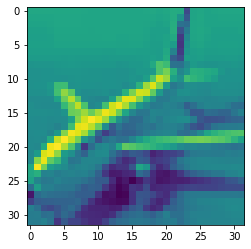

In [ ]:
img = samples[45][0]
_to_pil = transforms.ToPILImage()
plt.imshow(_to_pil(img))

In [ ]:
# DEFINE MODEL AND FORWARD PROPAGATION

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
     
    def forward(self, x):
        out = self.relu(self.linear1(x))
        out = self.relu(self.linear2(out))
        out = self.linear3(out)
        return out

In [ ]:
input_dim = 3*32*32
output_dim = 10
 
model = LogisticRegressionModel(input_dim, output_dim)

In [ ]:
model.to(avDev)

LogisticRegressionModel(
  (linear1): Linear(in_features=3072, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
criterion = nn.CrossEntropyLoss().to(avDev)

In [ ]:
learning_rate = 0.01
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 1e-5)


In [ ]:
# TRAINING AND CHECKING ACCURACY ON TEST

historyLoss = []
historyEpoch = []
gradientNorm = []

iter = 0
for epoch in range(num_epochs):
  
    for i, (images, labels) in enumerate(train_loader):
         
        #print(images.size()) #torch.Size([100, 1, 28, 28])
        #print(images.view(-1, 28*28).size()) #torch.Size([100, 784])
        images = images.view(-1, 32*32*3).to(avDev)
        labels = labels.to(avDev)
         
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)#
         
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Gradient norm for all learnable parameters
        total_norm = 0
        for p in model.parameters():
          if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)


        #for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #  print(p.grad.data.norm(2).item())
         
        # Updating parameters
        optimizer.step()
         
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 32*32*3).to(avDev)
                 
                # Forward pass only to get logits/output
                outputs = model(images)
                 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                correct += (predicted.cpu() == labels.cpu()).sum().float()

                
             
            accuracy = 100. * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

            print('Iteration: {}. Gradient Norm: {}'.format(iter, total_norm))

            historyEpoch.append(epoch)
            gradientNorm.append(total_norm)
            historyLoss.append(loss.item())
  

Iteration: 500. Loss: 2.0645222663879395. Accuracy: 27.889999389648438
Iteration: 500. Gradient Norm: 0.9984731084137075
Iteration: 1000. Loss: 1.9964683055877686. Accuracy: 32.369998931884766
Iteration: 1000. Gradient Norm: 1.7360462251890891
Iteration: 1500. Loss: 2.071830987930298. Accuracy: 33.470001220703125
Iteration: 1500. Gradient Norm: 2.582925346469592
Iteration: 2000. Loss: 1.7695322036743164. Accuracy: 35.560001373291016
Iteration: 2000. Gradient Norm: 1.4092297556418136
Iteration: 2500. Loss: 1.8005356788635254. Accuracy: 37.81999969482422
Iteration: 2500. Gradient Norm: 1.5479670579241473
Iteration: 3000. Loss: 1.726341962814331. Accuracy: 38.06999969482422
Iteration: 3000. Gradient Norm: 3.7408291338947643
Iteration: 3500. Loss: 1.6799885034561157. Accuracy: 40.15999984741211
Iteration: 3500. Gradient Norm: 1.4547637463466276
Iteration: 4000. Loss: 1.6050611734390259. Accuracy: 40.880001068115234
Iteration: 4000. Gradient Norm: 2.5667020260085383
Iteration: 4500. Loss: 1

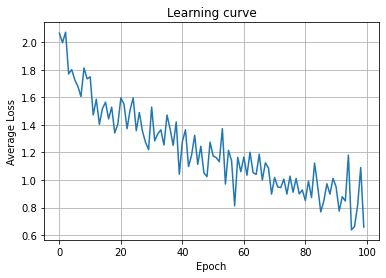

In [ ]:
# PLOT LOSS/ LEARNING CURVE
plt.plot(historyEpoch,historyLoss)  
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

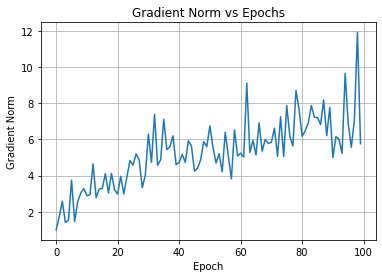

In [ ]:
# PLOT GRADIENT NORM VS EPOCHS

plt.plot(historyEpoch,gradientNorm)  
plt.title("Gradient Norm vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.grid(True)
plt.show()

In [ ]:
####################### CONFUSION MATRIX CALCULATION #####################################

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_preds = all_preds.to(avDev)
    for images,labels in loader:
        images = images.view(-1, 32*32*3).to(avDev)
        labels = labels.to(avDev)
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [ ]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                     
                                          shuffle=False)
    train_preds = get_all_preds(model, prediction_loader)

In [ ]:
trainset_targets = torch.IntTensor(trainset.targets)
trainset_targets = trainset_targets.to(avDev)

stacked = torch.stack(
    (
        trainset_targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [ ]:
cmt = torch.zeros(10,10, dtype=torch.int64)

In [ ]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [ ]:
print(cmt)  # PRINT CONFUSION MATRIX

tensor([[3314,  163,  123,   91,   82,   15,   37,   42,  682,  451],
        [  31, 4042,    1,   14,    3,    0,    8,    8,  159,  734],
        [ 255,   48, 2870,  413,  520,   84,  313,  113,  149,  235],
        [  77,   57,  228, 3420,  105,  216,  326,   77,  156,  338],
        [ 161,   41,  375,  342, 3175,   48,  252,  197,  214,  195],
        [  37,   43,  258, 1594,  172, 2129,  199,  170,  101,  297],
        [  26,   44,  161,  364,  189,   27, 3969,   23,   77,  120],
        [  62,   42,   97,  210,  164,   65,   42, 3884,   78,  356],
        [ 132,  125,   17,   35,   33,    2,   14,    3, 4380,  259],
        [  31,  135,    3,   30,   12,    7,   11,   12,  112, 4647]])

In [ ]:
# WE TRIED MULTIPLE ITERATIONS FOR THE FOLLOWING HYPERPARAMETERS AND GOT THE FOLLOWING BEST VALUES:

# 1. Number of Hidden Layers : 2
# 2. Number of Hidden Neurons : Layer 1: 512 , Layer 2: 128
# 3. Learning Rate : 0.01
# 4. Weight Decay : weight_decay = 1e-5
# 5. Number of Epochs : 100 (num_epochs = i / (len(trainset) / batch_size))
# 6. Batch Size : 100